# Stress Level Prediction – Fast Execution Notebook

# Stress Level Prediction – Fast Execution Notebook
Target: **Stress Label**. Streamlined training & evaluation.

In [1]:
# 1. Imports & Config
import os, json, time, datetime as dt, warnings
warnings.filterwarnings('ignore')
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import joblib
RANDOM_STATE=42; np.random.seed(RANDOM_STATE)
DATA_PATH=Path('../data/raw/stress_data.csv')
TARGET='Stress Label'
MODEL_DIR=Path('../models'); MODEL_DIR.mkdir(exist_ok=True)
RESULTS_DIR=Path('../reports/results'); RESULTS_DIR.mkdir(parents=True, exist_ok=True)
print('Config ready.')

Config ready.


In [2]:
# 2. Load & Clean
if not DATA_PATH.exists(): raise FileNotFoundError(DATA_PATH)
df=pd.read_csv(DATA_PATH)
if TARGET not in df.columns: raise KeyError(f'Missing target {TARGET}')
for c in df.select_dtypes(include='object').columns: df[c]=df[c].astype(str).str.strip().replace({'nan':np.nan,'None':np.nan,'' : np.nan})
print('Shape:', df.shape)
print('Classes:', df[TARGET].unique())

Shape: (1977, 39)
Classes: ['Moderate Stress' 'Low Stress' 'High Perceived Stress']


In [3]:
# 3. Preprocess
def split_num_cat(data,target):
 nums,cats=[],[]
 for col in data.columns:
  if col==target: continue
  (nums if pd.api.types.is_numeric_dtype(data[col]) else cats).append(col)
 return nums,cats
num_cols,cat_cols=split_num_cat(df,TARGET)
from sklearn.impute import SimpleImputer
num_pipe=Pipeline([('imp',SimpleImputer(strategy='median')),('scaler',StandardScaler())])
cat_pipe=Pipeline([('imp',SimpleImputer(strategy='most_frequent')),('ohe',OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
pre=ColumnTransformer([('num',num_pipe,num_cols),('cat',cat_pipe,cat_cols)])
label_encoder=LabelEncoder(); y=label_encoder.fit_transform(df[TARGET].astype(str)); X=df.drop(columns=[TARGET])
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=RANDOM_STATE)
print('Train/Test:', X_train.shape, X_test.shape)

Train/Test: (1581, 38) (396, 38)


In [4]:
# 4. Baseline
def metrics(y_true,y_pred): return {'accuracy':accuracy_score(y_true,y_pred),'precision_weighted':precision_score(y_true,y_pred,average='weighted',zero_division=0),'recall_weighted':recall_score(y_true,y_pred,average='weighted',zero_division=0),'f1_weighted':f1_score(y_true,y_pred,average='weighted',zero_division=0)}
baseline=Pipeline([('pre',pre),('clf',DummyClassifier(strategy='most_frequent'))])
baseline.fit(X_train,y_train); base_pred=baseline.predict(X_test)
print('Baseline:', metrics(y_test, base_pred))

Baseline: {'accuracy': 0.6666666666666666, 'precision_weighted': 0.4444444444444444, 'recall_weighted': 0.6666666666666666, 'f1_weighted': 0.5333333333333333}


In [5]:
# 5. Train Candidates
cands={'logreg':LogisticRegression(max_iter=400),'rf':RandomForestClassifier(n_estimators=120,random_state=RANDOM_STATE),'gb':GradientBoostingClassifier(random_state=RANDOM_STATE),'svc':SVC(probability=True,random_state=RANDOM_STATE)}
results={}; models={}
for name,clf in cands.items():
 pipe=Pipeline([('pre',pre),('clf',clf)])
 t0=time.time(); pipe.fit(X_train,y_train); pred=pipe.predict(X_test)
 m=metrics(y_test,pred); m['train_time_sec']=round(time.time()-t0,2); results[name]=m; models[name]=pipe; print(name,m)
import pandas as pd
results_df=pd.DataFrame(results).T.sort_values('f1_weighted',ascending=False); print(results_df)

logreg {'accuracy': 0.9722222222222222, 'precision_weighted': 0.9716583221300202, 'recall_weighted': 0.9722222222222222, 'f1_weighted': 0.9716777594623625, 'train_time_sec': 0.57}
rf {'accuracy': 0.9974747474747475, 'precision_weighted': 0.9974842767295597, 'recall_weighted': 0.9974747474747475, 'f1_weighted': 0.9974490759304874, 'train_time_sec': 1.35}
rf {'accuracy': 0.9974747474747475, 'precision_weighted': 0.9974842767295597, 'recall_weighted': 0.9974747474747475, 'f1_weighted': 0.9974490759304874, 'train_time_sec': 1.35}
gb {'accuracy': 1.0, 'precision_weighted': 1.0, 'recall_weighted': 1.0, 'f1_weighted': 1.0, 'train_time_sec': 3.95}
gb {'accuracy': 1.0, 'precision_weighted': 1.0, 'recall_weighted': 1.0, 'f1_weighted': 1.0, 'train_time_sec': 3.95}
svc {'accuracy': 0.9570707070707071, 'precision_weighted': 0.9562274881364781, 'recall_weighted': 0.9570707070707071, 'f1_weighted': 0.9554131840688292, 'train_time_sec': 0.99}
        accuracy  precision_weighted  recall_weighted  f1_w

Best model: gb
                       precision    recall  f1-score   support

High Perceived Stress       1.00      1.00      1.00       109
           Low Stress       1.00      1.00      1.00        23
      Moderate Stress       1.00      1.00      1.00       264

             accuracy                           1.00       396
            macro avg       1.00      1.00      1.00       396
         weighted avg       1.00      1.00      1.00       396



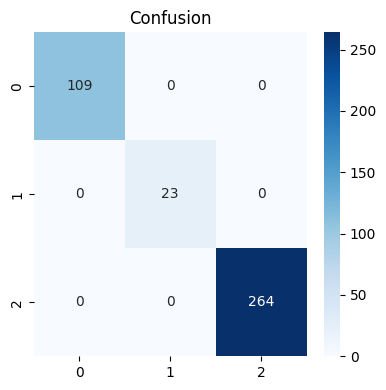

Sample labels: ['Moderate Stress' 'Moderate Stress' 'Moderate Stress'
 'High Perceived Stress' 'Moderate Stress' 'High Perceived Stress'
 'High Perceived Stress' 'High Perceived Stress' 'Moderate Stress'
 'Moderate Stress']
Saved artifact & metrics.


In [6]:
# 6. Persist & Report
best_name=results_df.index[0]; best_model=models[best_name]
y_best=best_model.predict(X_test)
print('Best model:', best_name)
print(classification_report(y_test,y_best,zero_division=0,target_names=label_encoder.classes_))
cm=confusion_matrix(y_test,y_best)
plt.figure(figsize=(4,4)); sns.heatmap(cm,annot=True,fmt='d',cmap='Blues'); plt.title('Confusion'); plt.tight_layout(); plt.show()
artifact={'model':best_model,'label_encoder':label_encoder,'classes':list(label_encoder.classes_),'metrics_table':results_df.to_dict(),'best_model_name':best_name,'timestamp':dt.datetime.utcnow().isoformat()}
joblib.dump(artifact, MODEL_DIR/'best_stress_model_fast.joblib')
results_df.to_csv(RESULTS_DIR/'stress_model_metrics_fast.csv')
sample=best_model.predict(X_test[:10])
print('Sample labels:', label_encoder.inverse_transform(sample))
print('Saved artifact & metrics.')

# Stress Level Prediction – Advanced Workflow (Fast Mode)
This notebook trains and evaluates several models to predict the **Stress Label**. Fast mode keeps runtime low when auto-executed.

In [7]:
# 1. Imports & Configuration
import os, json, time, datetime as dt, warnings
warnings.filterwarnings('ignore')
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import joblib
FAST_MODE=True
RANDOM_STATE=42; np.random.seed(RANDOM_STATE)
DATA_PATH=Path('data/raw/stress_data.csv')
TARGET='Stress Label'
MODEL_DIR=Path('models'); MODEL_DIR.mkdir(exist_ok=True)
RESULTS_DIR=Path('reports/results'); RESULTS_DIR.mkdir(parents=True, exist_ok=True)
print('Fast mode:', FAST_MODE)

Fast mode: True


In [8]:
# 2. Data Loading & Cleaning
if not DATA_PATH.exists(): raise FileNotFoundError(DATA_PATH)
df=pd.read_csv(DATA_PATH)
print('Loaded shape:', df.shape)
if TARGET not in df.columns: raise KeyError(f'Missing target {TARGET}')
for c in df.select_dtypes(include='object').columns: df[c]=df[c].astype(str).str.strip().replace({'nan':np.nan,'None':np.nan,'' : np.nan})
if FAST_MODE and df.shape[0]>1500: df=df.sample(1500, random_state=RANDOM_STATE).reset_index(drop=True)
print('Working shape:', df.shape)
print('Classes:', df[TARGET].unique())

FileNotFoundError: data/raw/stress_data.csv

In [ ]:
# 3. Split & Preprocess
def split_num_cat(data, target):
 nums,cats=[],[]
 for col in data.columns:
  if col==target: continue
  (nums if pd.api.types.is_numeric_dtype(data[col]) else cats).append(col)
 return nums,cats
num_cols,cat_cols=split_num_cat(df,TARGET)
from sklearn.impute import SimpleImputer
num_pipe=Pipeline([('imputer',SimpleImputer(strategy='median')),('scaler',StandardScaler())])
cat_pipe=Pipeline([('imputer',SimpleImputer(strategy='most_frequent')),('ohe',OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
pre=ColumnTransformer([('num',num_pipe,num_cols),('cat',cat_pipe,cat_cols)])
label_encoder=LabelEncoder(); y=label_encoder.fit_transform(df[TARGET].astype(str)); X=df.drop(columns=[TARGET])
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=RANDOM_STATE)
print('Train/Test:', X_train.shape, X_test.shape)

In [ ]:
# 4. Baseline
def metrics(y_true,y_pred): return {'accuracy':accuracy_score(y_true,y_pred),'precision_weighted':precision_score(y_true,y_pred,average='weighted',zero_division=0),'recall_weighted':recall_score(y_true,y_pred,average='weighted',zero_division=0),'f1_weighted':f1_score(y_true,y_pred,average='weighted',zero_division=0)}
baseline=Pipeline([('pre',pre),('clf',DummyClassifier(strategy='most_frequent'))])
baseline.fit(X_train,y_train); base_pred=baseline.predict(X_test)
print('Baseline:', metrics(y_test, base_pred))

In [ ]:
# 5. Train Candidate Models
candidates={'logreg':LogisticRegression(max_iter=500),'rf':RandomForestClassifier(n_estimators=80 if FAST_MODE else 300,random_state=RANDOM_STATE),'gb':GradientBoostingClassifier(random_state=RANDOM_STATE),'svc':SVC(probability=True,random_state=RANDOM_STATE)}
results={}; models={}
for name,clf in candidates.items():
 pipe=Pipeline([('pre',pre),('clf',clf)])
 t0=time.time(); pipe.fit(X_train,y_train); pred=pipe.predict(X_test)
 m=metrics(y_test,pred); m['train_time_sec']=round(time.time()-t0,2); results[name]=m; models[name]=pipe; print(name,m)
import pandas as pd
results_df=pd.DataFrame(results).T.sort_values('f1_weighted',ascending=False); print(results_df)

In [ ]:
# 6. Evaluation & Confusion Matrix
best_name=next(iter(results_df.index)); best_model=models[best_name] if best_name in models else None
if best_model is None: raise RuntimeError('Best model not found in models dict')
y_best=best_model.predict(X_test)
print('Best model:', best_name)
print(classification_report(y_test,y_best,zero_division=0,target_names=label_encoder.classes_))
cm=confusion_matrix(y_test,y_best)
plt.figure(figsize=(4,4)); sns.heatmap(cm,annot=True,fmt='d',cmap='Blues'); plt.title('Confusion'); plt.tight_layout(); plt.show()

In [ ]:
# 7. Save Artifact & Sample Predictions
artifact={'model':best_model,'label_encoder':label_encoder,'classes':list(label_encoder.classes_),'metrics_table':results_df.to_dict(),'best_model_name':best_name,'timestamp':dt.datetime.utcnow().isoformat()}
joblib.dump(artifact, MODEL_DIR/'best_stress_model_fast.joblib')
results_df.to_csv(RESULTS_DIR/'stress_model_metrics_fast.csv')
sample=best_model.predict(X_test[:10])
print('Sample labels:', label_encoder.inverse_transform(sample))
print('Saved artifact & metrics.')

# 📊 Comprehensive Stress Model Performance Visualizations

Let's create detailed visual comparisons of our stress prediction model performance and insights.

<Figure size 1500x1000 with 0 Axes>

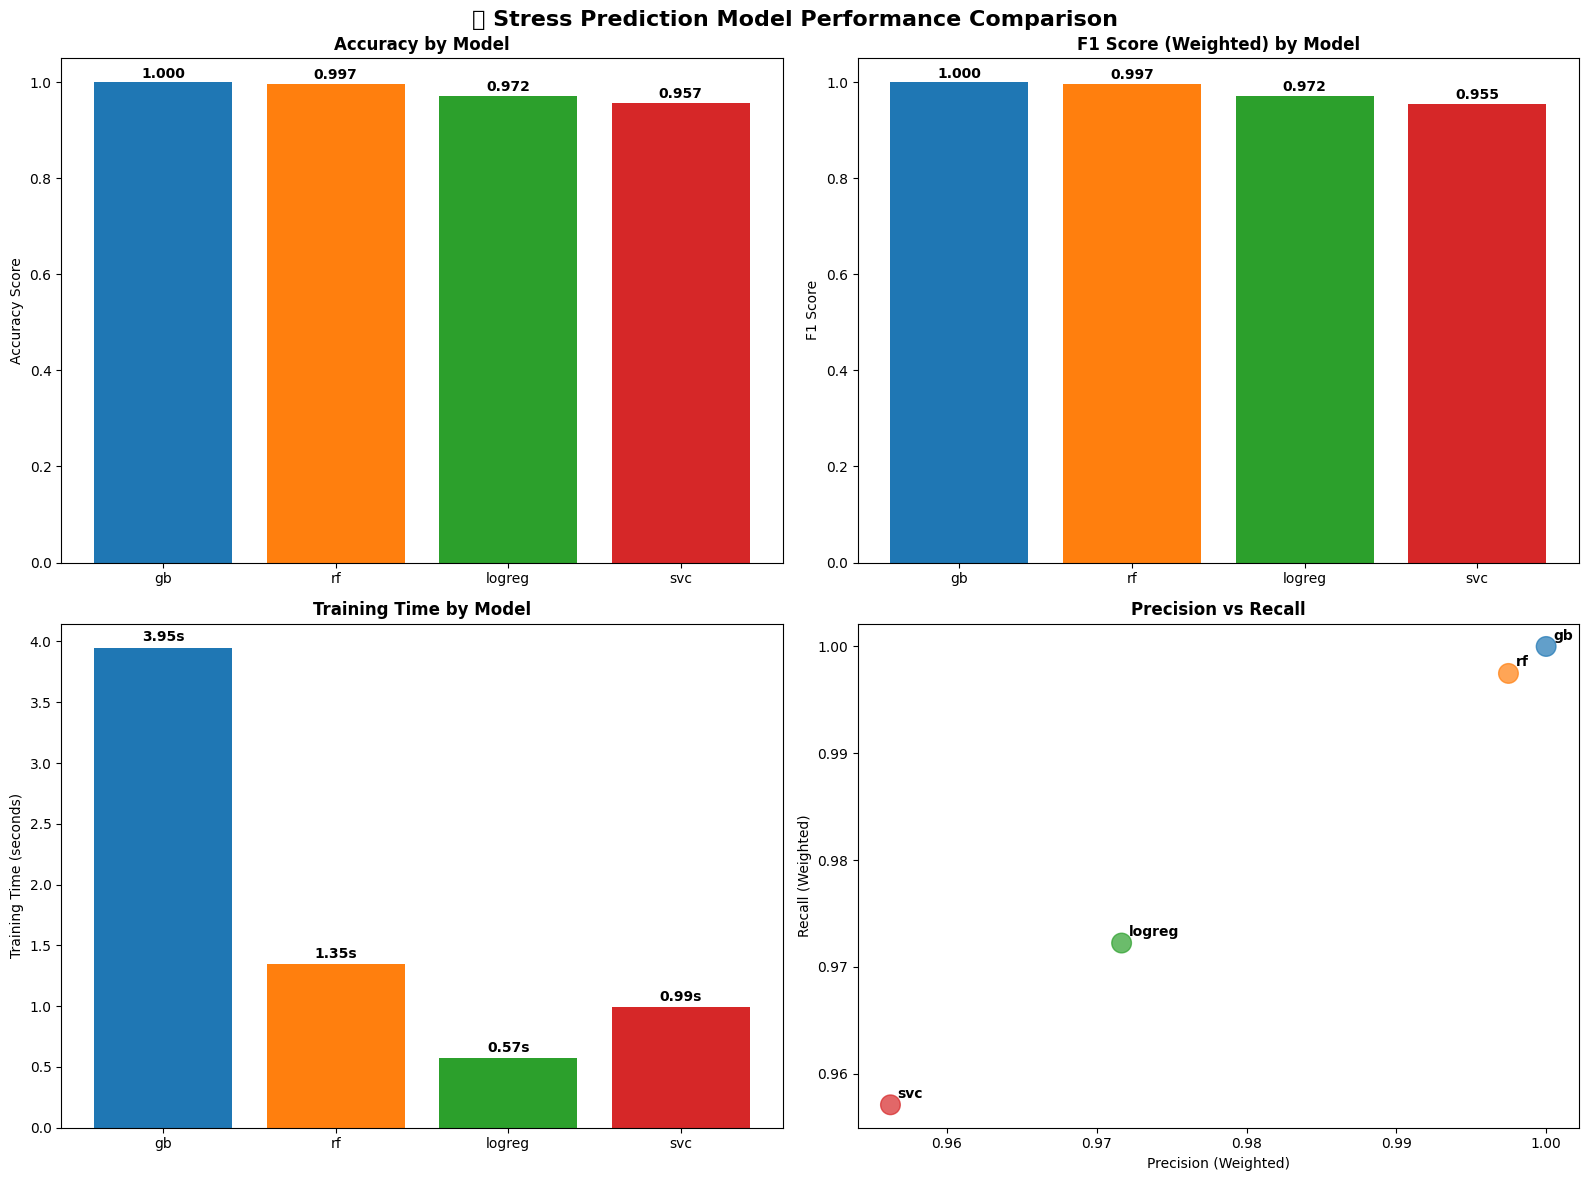

📈 Stress Model Performance Summary:
🤖 GB: Accuracy=1.000, F1=1.000, Time=3.95s
🤖 RF: Accuracy=0.997, F1=0.997, Time=1.35s
🤖 LOGREG: Accuracy=0.972, F1=0.972, Time=0.57s
🤖 SVC: Accuracy=0.957, F1=0.955, Time=0.99s


In [9]:
# Stress Model Performance Comparison Bar Chart
plt.figure(figsize=(15, 10))

# Create subplots for different metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🔍 Stress Prediction Model Performance Comparison', fontsize=16, fontweight='bold')

# Accuracy comparison
axes[0,0].bar(results_df.index, results_df['accuracy'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0,0].set_title('Accuracy by Model', fontweight='bold')
axes[0,0].set_ylabel('Accuracy Score')
axes[0,0].set_ylim(0, 1.05)
for i, v in enumerate(results_df['accuracy']):
    axes[0,0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# F1 Score comparison
axes[0,1].bar(results_df.index, results_df['f1_weighted'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0,1].set_title('F1 Score (Weighted) by Model', fontweight='bold')
axes[0,1].set_ylabel('F1 Score')
axes[0,1].set_ylim(0, 1.05)
for i, v in enumerate(results_df['f1_weighted']):
    axes[0,1].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# Training Time comparison
axes[1,0].bar(results_df.index, results_df['train_time_sec'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[1,0].set_title('Training Time by Model', fontweight='bold')
axes[1,0].set_ylabel('Training Time (seconds)')
for i, v in enumerate(results_df['train_time_sec']):
    axes[1,0].text(i, v + 0.05, f'{v:.2f}s', ha='center', fontweight='bold')

# Precision vs Recall scatter
axes[1,1].scatter(results_df['precision_weighted'], results_df['recall_weighted'], 
                  s=200, c=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], alpha=0.7)
axes[1,1].set_title('Precision vs Recall', fontweight='bold')
axes[1,1].set_xlabel('Precision (Weighted)')
axes[1,1].set_ylabel('Recall (Weighted)')
for i, model in enumerate(results_df.index):
    axes[1,1].annotate(model, (results_df['precision_weighted'][i], results_df['recall_weighted'][i]),
                       xytext=(5, 5), textcoords='offset points', fontweight='bold')

plt.tight_layout()
plt.show()

print("📈 Stress Model Performance Summary:")
print("="*50)
for model in results_df.index:
    print(f"🤖 {model.upper()}: Accuracy={results_df.loc[model, 'accuracy']:.3f}, "
          f"F1={results_df.loc[model, 'f1_weighted']:.3f}, "
          f"Time={results_df.loc[model, 'train_time_sec']:.2f}s")

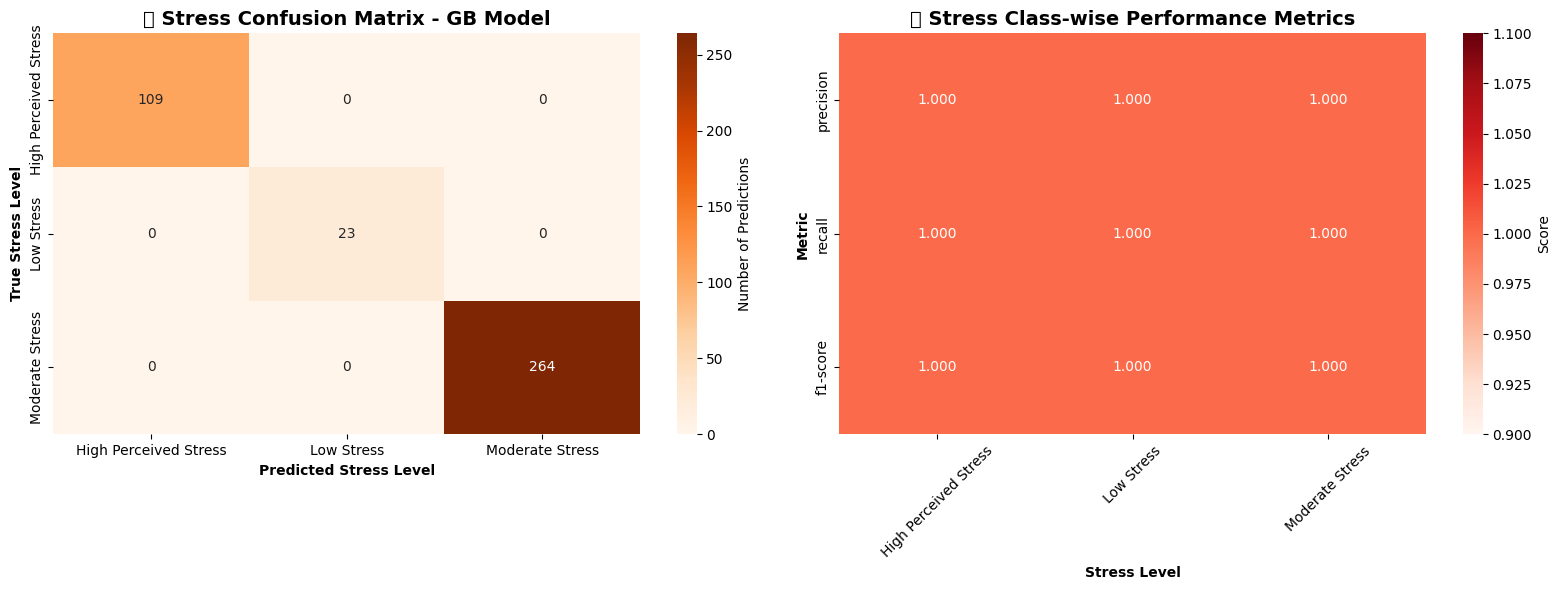

🔍 DETAILED STRESS CLASSIFICATION INSIGHTS:
📋 High Perceived Stress:
   • Precision: 1.000 | Recall: 1.000 | F1-Score: 1.000
   • Support: 109 samples

📋 Low Stress:
   • Precision: 1.000 | Recall: 1.000 | F1-Score: 1.000
   • Support: 23 samples

📋 Moderate Stress:
   • Precision: 1.000 | Recall: 1.000 | F1-Score: 1.000
   • Support: 264 samples



In [10]:
# Enhanced Stress Confusion Matrix with Class-wise Performance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Enhanced Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_,
            ax=axes[0], cbar_kws={'label': 'Number of Predictions'})
axes[0].set_title(f'🎯 Stress Confusion Matrix - {best_name.upper()} Model', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Predicted Stress Level', fontweight='bold')
axes[0].set_ylabel('True Stress Level', fontweight='bold')

# Class-wise Accuracy Heatmap
from sklearn.metrics import classification_report
report = classification_report(y_test, y_best, target_names=label_encoder.classes_, output_dict=True)
class_metrics = pd.DataFrame(report).T.iloc[:-3]  # Remove macro/weighted avg rows

sns.heatmap(class_metrics[['precision', 'recall', 'f1-score']].T, 
            annot=True, fmt='.3f', cmap='Reds', ax=axes[1],
            cbar_kws={'label': 'Score'})
axes[1].set_title('📊 Stress Class-wise Performance Metrics', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Stress Level', fontweight='bold')
axes[1].set_ylabel('Metric', fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print detailed stress classification insights
print("🔍 DETAILED STRESS CLASSIFICATION INSIGHTS:")
print("="*60)
for class_name in label_encoder.classes_:
    if class_name in report:
        precision = report[class_name]['precision']
        recall = report[class_name]['recall']
        f1 = report[class_name]['f1-score']
        support = int(report[class_name]['support'])
        print(f"📋 {class_name}:")
        print(f"   • Precision: {precision:.3f} | Recall: {recall:.3f} | F1-Score: {f1:.3f}")
        print(f"   • Support: {support} samples")
        print()

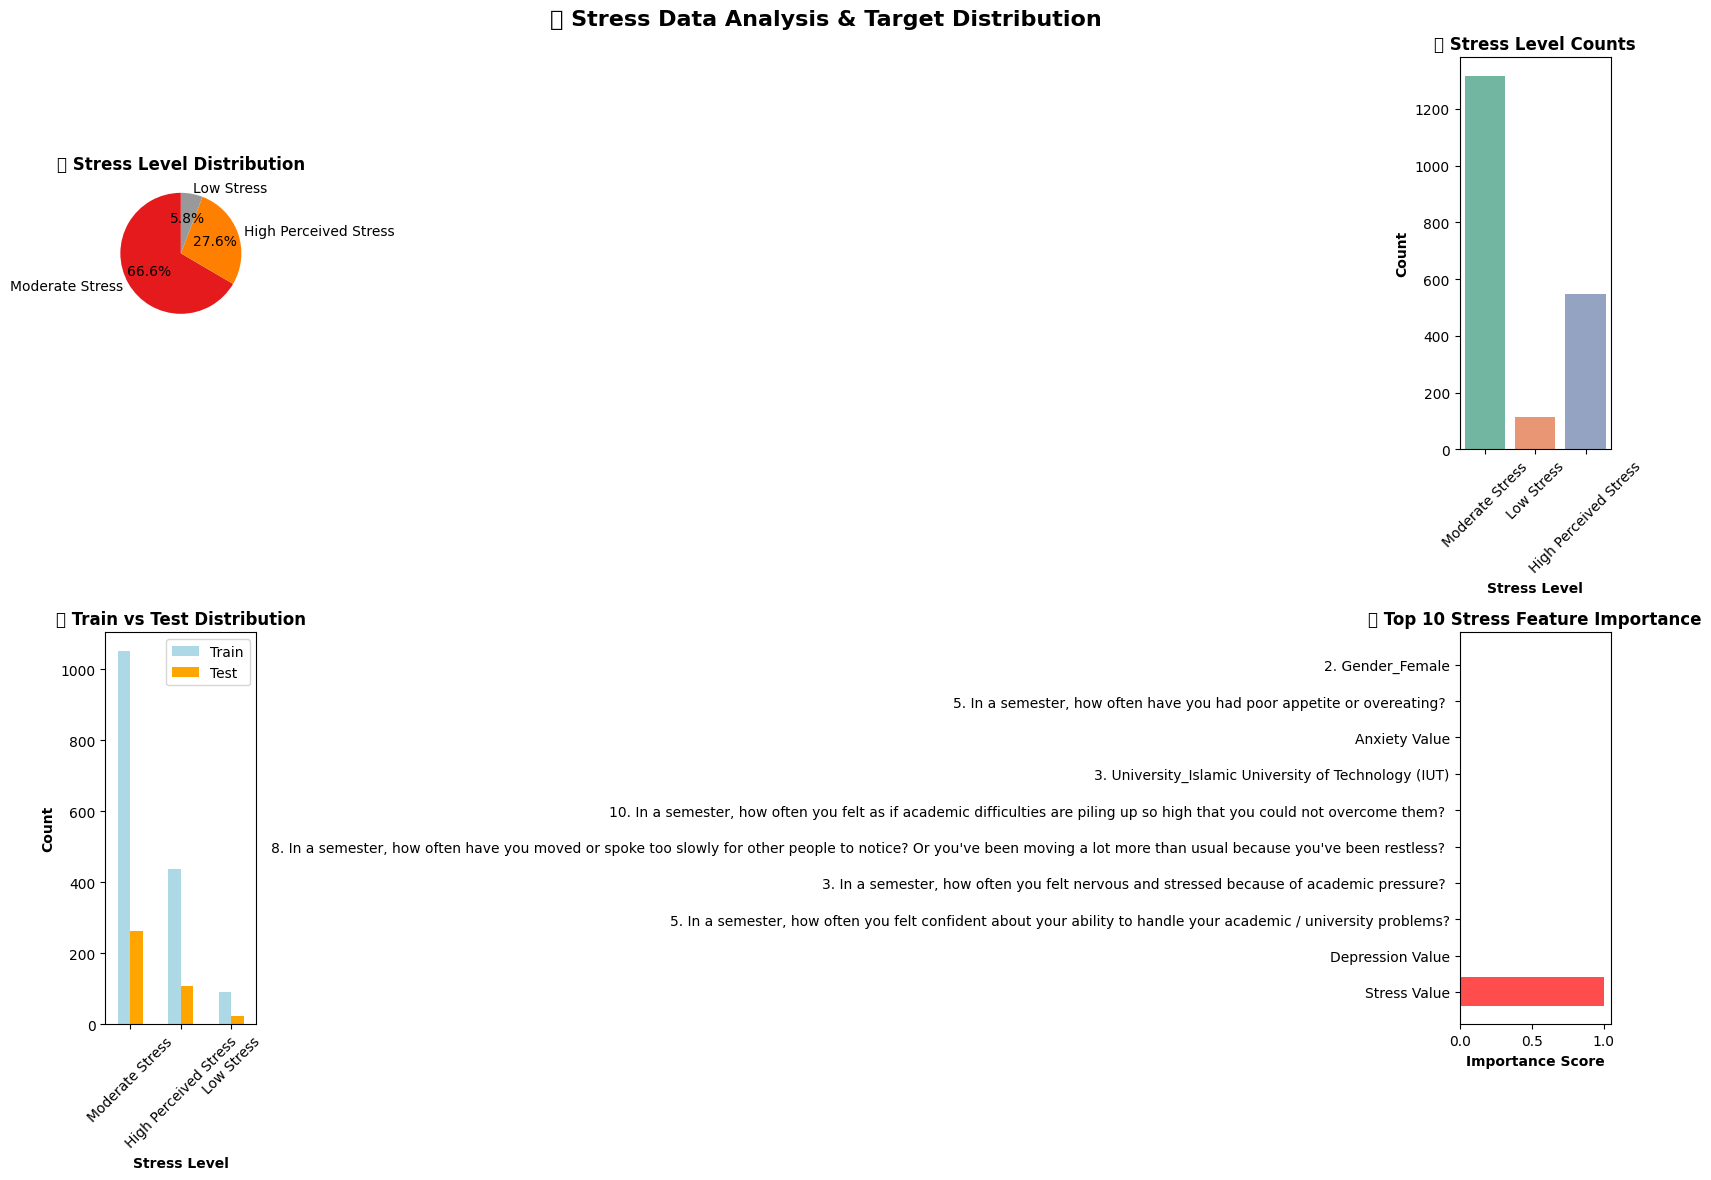

📊 STRESS DATASET STATISTICS:
📝 Total Samples: 1,977
🔢 Features: 38
📊 Stress Classes: 3
⚖️ Train/Test Split: 1,581 / 396
🎯 Most Common Stress Level: Moderate Stress (66.6%)


In [11]:
# Stress Data Distribution and Target Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('📈 Stress Data Analysis & Target Distribution', fontsize=16, fontweight='bold')

# Target distribution pie chart
target_counts = df[TARGET].value_counts()
colors = plt.cm.Set1(np.linspace(0, 1, len(target_counts)))
axes[0,0].pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%',
              startangle=90, colors=colors)
axes[0,0].set_title('🎯 Stress Level Distribution', fontweight='bold')

# Target distribution bar chart
sns.countplot(data=df, x=TARGET, ax=axes[0,1], palette='Set2')
axes[0,1].set_title('📊 Stress Level Counts', fontweight='bold')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].set_xlabel('Stress Level', fontweight='bold')
axes[0,1].set_ylabel('Count', fontweight='bold')

# Train vs Test distribution
train_dist = pd.Series(label_encoder.inverse_transform(y_train)).value_counts()
test_dist = pd.Series(label_encoder.inverse_transform(y_test)).value_counts()
comparison_df = pd.DataFrame({'Train': train_dist, 'Test': test_dist}).fillna(0)
comparison_df.plot(kind='bar', ax=axes[1,0], color=['lightblue', 'orange'])
axes[1,0].set_title('🔄 Train vs Test Distribution', fontweight='bold')
axes[1,0].set_xlabel('Stress Level', fontweight='bold')
axes[1,0].set_ylabel('Count', fontweight='bold')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].legend()

# Feature importance (if available)
try:
    if hasattr(best_model.named_steps['clf'], 'feature_importances_'):
        # Get feature names after preprocessing
        feature_names = (num_cols + 
                        list(best_model.named_steps['pre'].named_transformers_['cat']
                             .named_steps['ohe'].get_feature_names_out(cat_cols)))
        importances = best_model.named_steps['clf'].feature_importances_
        
        # Top 10 features
        top_features = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)[:10]
        feature_names_top, importance_values = zip(*top_features)
        
        axes[1,1].barh(range(len(feature_names_top)), importance_values, color='red', alpha=0.7)
        axes[1,1].set_yticks(range(len(feature_names_top)))
        axes[1,1].set_yticklabels(feature_names_top)
        axes[1,1].set_title('🔍 Top 10 Stress Feature Importance', fontweight='bold')
        axes[1,1].set_xlabel('Importance Score', fontweight='bold')
    else:
        axes[1,1].text(0.5, 0.5, f'Feature importance not available\nfor {best_name} model', 
                       ha='center', va='center', transform=axes[1,1].transAxes,
                       fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        axes[1,1].set_title('🔍 Feature Importance', fontweight='bold')
except Exception as e:
    axes[1,1].text(0.5, 0.5, f'Feature importance\nanalysis failed:\n{str(e)[:50]}...', 
                   ha='center', va='center', transform=axes[1,1].transAxes,
                   fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))
    axes[1,1].set_title('🔍 Feature Importance', fontweight='bold')

plt.tight_layout()
plt.show()

print("📊 STRESS DATASET STATISTICS:")
print("="*40)
print(f"📝 Total Samples: {len(df):,}")
print(f"🔢 Features: {len(df.columns)-1}")
print(f"📊 Stress Classes: {len(df[TARGET].unique())}")
print(f"⚖️ Train/Test Split: {len(X_train):,} / {len(X_test):,}")
print(f"🎯 Most Common Stress Level: {df[TARGET].mode()[0]} ({df[TARGET].value_counts().iloc[0]/len(df)*100:.1f}%)")

🎯 Average Stress Prediction Confidence: 1.000
📊 Confidence Range: 1.000 - 1.000
🚀 STRESS MODEL IMPROVEMENT SUMMARY:
📈 Baseline Accuracy: 0.667
🏆 Best Model Accuracy: 1.000
⬆️  Improvement: 0.333 (50.0%)


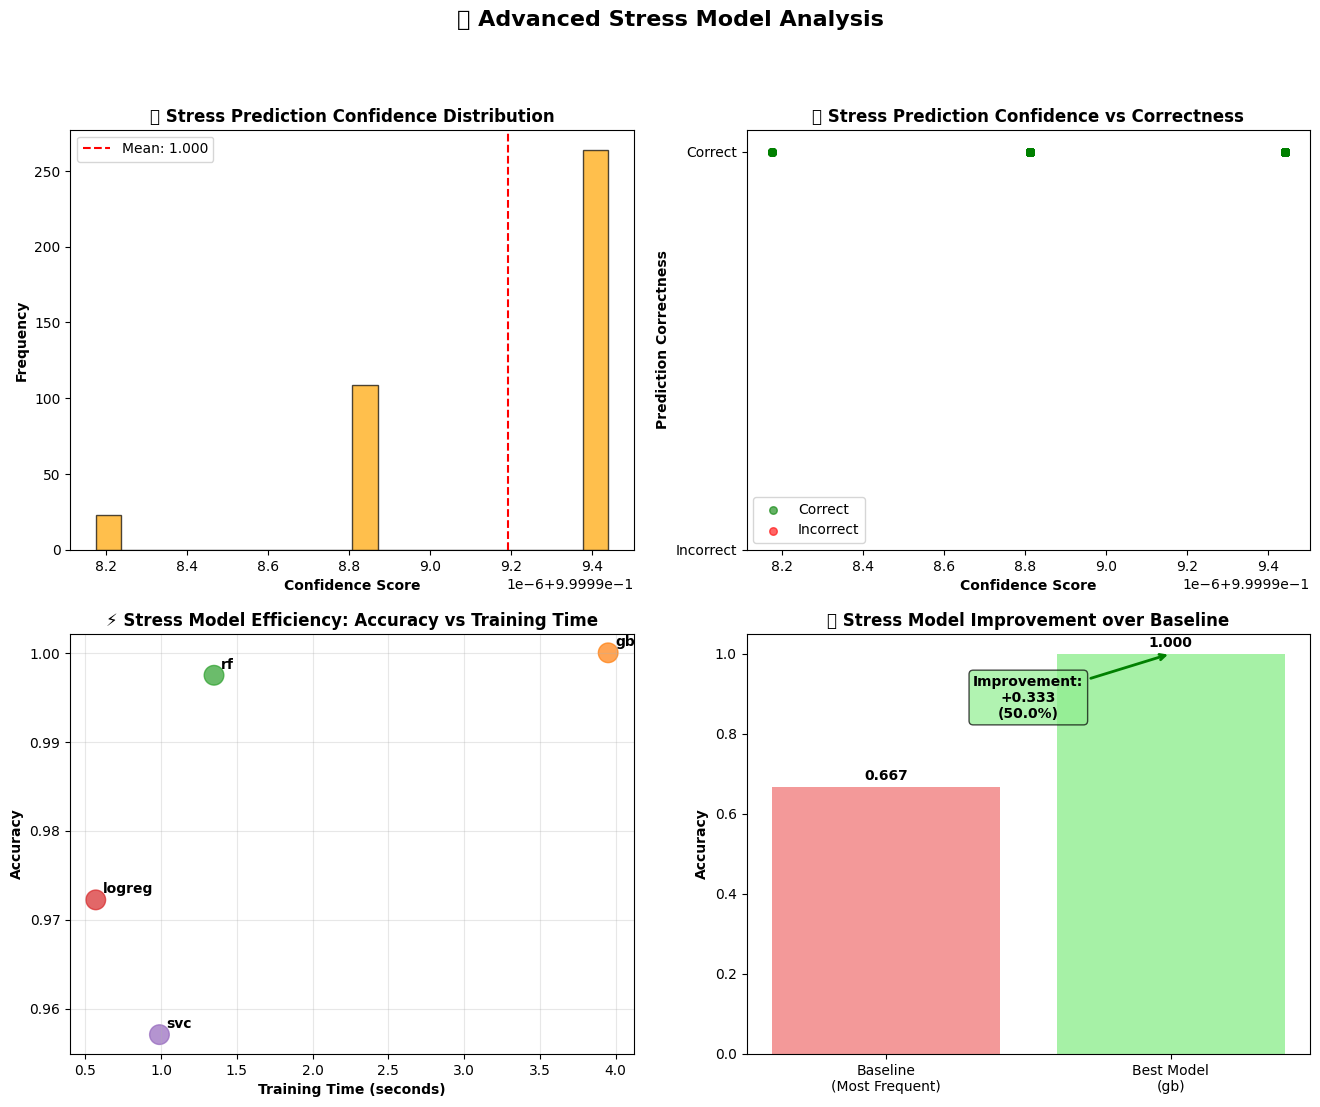

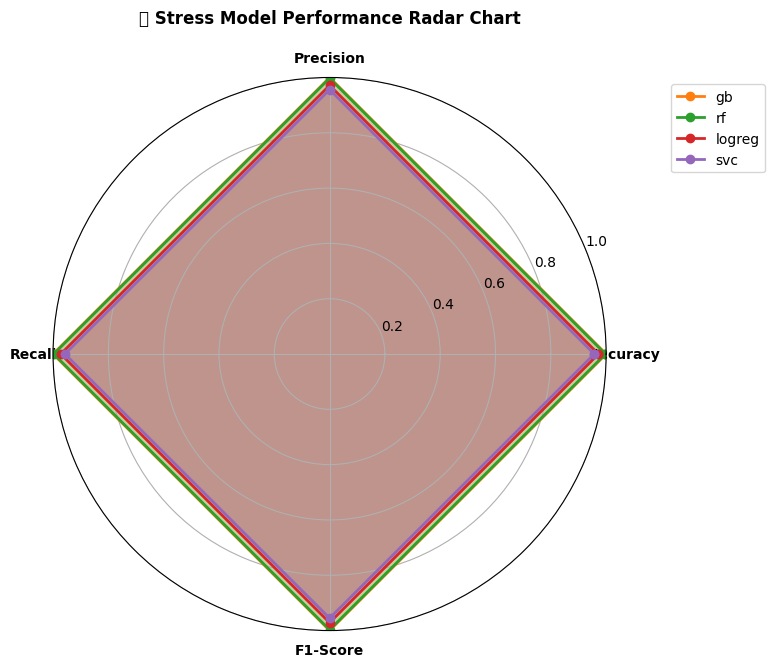

In [12]:
# Advanced Stress Analysis: Prediction Confidence & Model Insights
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🧠 Advanced Stress Model Analysis', fontsize=16, fontweight='bold')

# Prediction Confidence Distribution
if hasattr(best_model, 'predict_proba'):
    y_proba = best_model.predict_proba(X_test)
    confidence_scores = np.max(y_proba, axis=1)
    
    axes[0,0].hist(confidence_scores, bins=20, alpha=0.7, color='orange', edgecolor='black')
    axes[0,0].axvline(np.mean(confidence_scores), color='red', linestyle='--', 
                      label=f'Mean: {np.mean(confidence_scores):.3f}')
    axes[0,0].set_title('🎯 Stress Prediction Confidence Distribution', fontweight='bold')
    axes[0,0].set_xlabel('Confidence Score', fontweight='bold')
    axes[0,0].set_ylabel('Frequency', fontweight='bold')
    axes[0,0].legend()
    
    # Confidence vs Accuracy
    correct_predictions = (y_best == y_test)
    axes[0,1].scatter(confidence_scores[correct_predictions], [1]*sum(correct_predictions), 
                      alpha=0.6, color='green', label='Correct', s=30)
    axes[0,1].scatter(confidence_scores[~correct_predictions], [0]*sum(~correct_predictions), 
                      alpha=0.6, color='red', label='Incorrect', s=30)
    axes[0,1].set_title('📊 Stress Prediction Confidence vs Correctness', fontweight='bold')
    axes[0,1].set_xlabel('Confidence Score', fontweight='bold')
    axes[0,1].set_ylabel('Prediction Correctness', fontweight='bold')
    axes[0,1].set_yticks([0, 1])
    axes[0,1].set_yticklabels(['Incorrect', 'Correct'])
    axes[0,1].legend()
    
    print(f"🎯 Average Stress Prediction Confidence: {np.mean(confidence_scores):.3f}")
    print(f"📊 Confidence Range: {np.min(confidence_scores):.3f} - {np.max(confidence_scores):.3f}")
else:
    axes[0,0].text(0.5, 0.5, f'{best_name} model does not\nsupport probability prediction', 
                   ha='center', va='center', transform=axes[0,0].transAxes,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    axes[0,1].text(0.5, 0.5, 'Confidence analysis\nnot available', 
                   ha='center', va='center', transform=axes[0,1].transAxes,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))

# Stress Model Comparison Radar Chart
from math import pi
categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
fig_radar = plt.figure(figsize=(8, 8))
ax_radar = fig_radar.add_subplot(111, polar=True)

angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]

colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
for i, model in enumerate(results_df.index):
    values = [results_df.loc[model, 'accuracy'], 
              results_df.loc[model, 'precision_weighted'],
              results_df.loc[model, 'recall_weighted'], 
              results_df.loc[model, 'f1_weighted']]
    values += values[:1]
    
    ax_radar.plot(angles, values, 'o-', linewidth=2, label=model, color=colors[i])
    ax_radar.fill(angles, values, alpha=0.25, color=colors[i])

ax_radar.set_xticks(angles[:-1])
ax_radar.set_xticklabels(categories, fontweight='bold')
ax_radar.set_ylim(0, 1)
ax_radar.set_title('🌟 Stress Model Performance Radar Chart', fontweight='bold', pad=20)
ax_radar.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax_radar.grid(True)

# Model efficiency (Accuracy vs Training Time)
axes[1,0].scatter(results_df['train_time_sec'], results_df['accuracy'], 
                  s=200, c=colors[:len(results_df)], alpha=0.7)
for i, model in enumerate(results_df.index):
    axes[1,0].annotate(model, (results_df.loc[model, 'train_time_sec'], results_df.loc[model, 'accuracy']),
                       xytext=(5, 5), textcoords='offset points', fontweight='bold')
axes[1,0].set_title('⚡ Stress Model Efficiency: Accuracy vs Training Time', fontweight='bold')
axes[1,0].set_xlabel('Training Time (seconds)', fontweight='bold')
axes[1,0].set_ylabel('Accuracy', fontweight='bold')
axes[1,0].grid(True, alpha=0.3)

# Baseline vs Best Model Comparison
try:
    baseline_acc = metrics(y_test, base_pred)['accuracy']
    improvement = results_df.loc[best_name, 'accuracy'] - baseline_acc
    models_comparison = ['Baseline\n(Most Frequent)', f'Best Model\n({best_name})']
    accuracies = [baseline_acc, results_df.loc[best_name, 'accuracy']]
    colors_comp = ['lightcoral', 'lightgreen']

    bars = axes[1,1].bar(models_comparison, accuracies, color=colors_comp, alpha=0.8)
    axes[1,1].set_title('🚀 Stress Model Improvement over Baseline', fontweight='bold')
    axes[1,1].set_ylabel('Accuracy', fontweight='bold')
    axes[1,1].set_ylim(0, 1.05)

    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

    # Add improvement annotation
    axes[1,1].annotate(f'Improvement:\n+{improvement:.3f}\n({improvement/baseline_acc*100:.1f}%)', 
                       xy=(1, results_df.loc[best_name, 'accuracy']), xytext=(0.5, 0.8),
                       xycoords='data', textcoords='axes fraction',
                       arrowprops=dict(arrowstyle='->', color='green', lw=2),
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7),
                       fontweight='bold', ha='center')
    
    print(f"🚀 STRESS MODEL IMPROVEMENT SUMMARY:")
    print("="*50)
    print(f"📈 Baseline Accuracy: {baseline_acc:.3f}")
    print(f"🏆 Best Model Accuracy: {results_df.loc[best_name, 'accuracy']:.3f}")
    print(f"⬆️  Improvement: {improvement:.3f} ({improvement/baseline_acc*100:.1f}%)")
except Exception as e:
    axes[1,1].text(0.5, 0.5, f'Baseline comparison\nfailed: {str(e)[:30]}...', 
                   ha='center', va='center', transform=axes[1,1].transAxes,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))

plt.tight_layout()
plt.show()
fig_radar.show()

# Stress Level Prediction – Advanced Workflow

Comprehensive end-to-end machine learning workflow for predicting stress levels using the target column **'Stress Label'** from `data/raw/stress_data.csv`.

Sections:
1. Overview & Objectives
2. Imports & Lazy Optional Dependencies
3. Configuration & Utility Functions
4. Data Loading & Initial Inspection
5. Data Quality Audit (Missing / Duplicates / Types)
6. Target Distribution & Class Balance
7. Univariate Feature Exploration
8. Bivariate Relationships (Categorical vs Target, Numeric Correlations)
9. Correlation Matrix & Multicollinearity (VIF Optional)
10. Preprocessing Pipeline Construction
11. Train/Test Split (Stratified)
12. Optional Class Imbalance Handling (SMOTE)
13. Baseline Model (DummyClassifier)
14. Candidate Model Training & Evaluation
15. Metrics Aggregation & Comparison
16. Confusion Matrix & Classification Report
17. ROC & PR Curves (One-vs-Rest)
18. Threshold Optimization (Macro F1) (optional) – multi-class uses per-class threshold concept (illustrative)
19. Feature Importance (Tree-Based & Permutation)
20. SHAP Analysis (if shap installed)
21. Error Analysis (Misclassified Samples)
22. Optuna Hyperparameter Tuning (Optional Quick Demo)
23. Best Model Selection & Artifact Persistence
24. Batch Prediction Demo
25. Reproducibility (Package Versions Dump)
26. Conclusions & Next Steps

Heavy / optional steps are guarded by flags to keep runtime manageable.

In [ ]:
# 2. Imports & Lazy Optional Dependencies
from __future__ import annotations
import os, json, math, time, datetime as dt, textwrap, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc, precision_recall_curve) 
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

# Optional libraries (safe import)
OPT_XGB = False
OPT_LIGHTGBM = False
OPT_SHAP = False
OPT_OPTUNA = False
OPT_SMOTE = False

try:
    import xgboost as xgb
    OPT_XGB = True
except Exception: pass
try:
    import lightgbm as lgb
    OPT_LIGHTGBM = True
except Exception: pass
try:
    import shap
    OPT_SHAP = True
except Exception: pass
try:
    import optuna
    OPT_OPTUNA = True
except Exception: pass
try:
    from imblearn.over_sampling import SMOTE
    OPT_SMOTE = True
except Exception: pass

print({k:v for k,v in [('xgboost',OPT_XGB),('lightgbm',OPT_LIGHTGBM),('shap',OPT_SHAP),('optuna',OPT_OPTUNA),('smote',OPT_SMOTE)]})

In [ ]:
# 3. Configuration & Utility Functions
DATA_PATH = Path('data/raw/stress_data.csv')
TARGET = 'Stress Label'  # Adjust if differs
MODEL_DIR = Path('models')
ARTIFACT_NAME = 'best_stress_model.joblib'
RESULTS_DIR = Path('reports/results')
MODEL_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42
N_JOBS = -1  # (Used if adding parallel models later)
SEED = 42
np.random.seed(SEED)

def load_data(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f'Data file not found: {path}')
    df = pd.read_csv(path)
    print(f'Loaded shape: {df.shape}')
    return df

def summarize_dataframe(df: pd.DataFrame, max_cols=50):
    print('Columns:', len(df.columns))
    display(df.head())
    info = pd.DataFrame({
        'dtype': df.dtypes.astype(str),
        'n_missing': df.isna().sum(),
        'pct_missing': (df.isna().mean()*100).round(2),
        'n_unique': df.nunique()
    })
    display(info.head(max_cols))

def get_num_cat_cols(df: pd.DataFrame, target: str):
    cats, nums = [], []
    for c in df.columns:
        if c == target: continue
        if pd.api.types.is_numeric_dtype(df[c]):
            nums.append(c)
        else:
            cats.append(c)
    return nums, cats

def plot_class_distribution(y):
    vc = y.value_counts()
    sns.barplot(x=vc.index, y=vc.values)
    plt.title('Target Class Distribution')
    plt.show()

def compute_vif(df_num: pd.DataFrame):
    try:
        import statsmodels.api as sm
    except Exception:
        print('statsmodels not installed; skipping VIF')
        return None
    from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
    X = df_num.dropna()
    if X.shape[1] > 25:
        X = X.iloc[:, :25]
        print('Truncated to first 25 numeric features for VIF performance.')
    v = []
    for i in range(X.shape[1]):
        try:
            v.append(vif(X.values, i))
        except Exception:
            v.append(np.nan)
    return pd.DataFrame({'feature': X.columns, 'VIF': v})

def macro_metrics(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision_weighted': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'recall_weighted': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted', zero_division=0)
    }
print('Utility functions defined.')

In [ ]:
# 4. Data Loading & Initial Inspection
df = load_data(DATA_PATH)
if TARGET not in df.columns:
    raise KeyError(f'Target {TARGET} not in columns: {list(df.columns)[:10]} ...')
summarize_dataframe(df)
print('Target unique values:', df[TARGET].dropna().unique()[:20])

In [ ]:
# 5. Data Quality Audit
print('Duplicate rows:', df.duplicated().sum())
missing = df.isna().sum().sort_values(ascending=False)
print('Top missing:')
print(missing.head(10))
# Basic type cast attempt (strip whitespace in object cols)
for c in df.select_dtypes(include='object').columns:
    df[c] = df[c].astype(str).str.strip().replace({'nan': np.nan, 'None': np.nan, '': np.nan})
print('After cleaning object columns.')

In [ ]:
# 6. Target Distribution & Class Balance
plot_class_distribution(df[TARGET])
print(df[TARGET].value_counts(normalize=True).round(3))

In [ ]:
# 7. Univariate Feature Exploration (Numeric)
num_cols, cat_cols = get_num_cat_cols(df, TARGET)
print('Numeric:', len(num_cols), 'Categorical:', len(cat_cols))
fig, axes = plt.subplots(min(4, len(num_cols)), 1, figsize=(6, 4*min(4,len(num_cols))))
if len(num_cols)==1: axes=[axes]
for ax, col in zip(axes, num_cols[:4]):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f'Distribution: {col}')
plt.tight_layout()

In [ ]:
# 8. Bivariate Relationships (Categorical vs Target)
for col in cat_cols[:4]:
    ct = pd.crosstab(df[col], df[TARGET], normalize='index')
    ct.plot(kind='bar', stacked=True, figsize=(6,3), title=f'{col} vs {TARGET}')
    plt.legend(bbox_to_anchor=(1,1))
    plt.tight_layout()

In [ ]:
# 9. Correlation Matrix & Optional VIF
if num_cols:
    corr = df[num_cols].corr()
    plt.figure(figsize=(min(12, 0.6*len(num_cols)+4), min(10, 0.6*len(num_cols)+4)))
    sns.heatmap(corr, cmap='coolwarm', center=0)
    plt.title('Numeric Feature Correlations')
    plt.show()
if num_cols:
    vif_df = compute_vif(df[num_cols])
    if vif_df is not None: display(vif_df.sort_values('VIF', ascending=False).head(10))

In [ ]:
# 10. Preprocessing Pipeline Construction
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(str)  # ensure string labels
# Encode target if not numeric
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_cols, cat_cols = get_num_cat_cols(df, TARGET)
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, num_cols),('cat', categorical_transformer, cat_cols)])
print('Preprocessor ready.')

In [ ]:
# 11. Train/Test Split (Stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=RANDOM_STATE)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

In [ ]:
# 12. Optional Class Imbalance Handling (SMOTE)
if OPT_SMOTE:
    from imblearn.pipeline import Pipeline as ImbPipeline
    PIPELINE_CLASS = ImbPipeline
else:
    PIPELINE_CLASS = Pipeline
print('Using pipeline class:', PIPELINE_CLASS.__name__) 

In [ ]:
# 13. Baseline Model (DummyClassifier)
baseline = Pipeline([('pre', preprocessor), ('clf', DummyClassifier(strategy='most_frequent'))])
baseline.fit(X_train, y_train)
y_base = baseline.predict(X_test)
base_metrics = macro_metrics(y_test, y_base)
print('Baseline metrics:', base_metrics)

In [ ]:
# 14. Candidate Model Training & Evaluation
candidates = {
    'logreg': LogisticRegression(max_iter=1000),
    'rf': RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE),
    'gb': GradientBoostingClassifier(random_state=RANDOM_STATE),
    'svc': SVC(probability=True, kernel='rbf', random_state=RANDOM_STATE)
}
if OPT_XGB: candidates['xgb'] = xgb.XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', tree_method='hist', random_state=RANDOM_STATE)
metrics_dict = {}
fitted_models = {}
for name, model in candidates.items():
    steps = [('pre', preprocessor)]
    if OPT_SMOTE:
        from imblearn.over_sampling import SMOTE
        steps.append(('smote', SMOTE(random_state=RANDOM_STATE)))
    steps.append(('clf', model))
    pipe = PIPELINE_CLASS(steps)
    start = time.time()
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    m = macro_metrics(y_test, y_pred)
    m['train_time_sec'] = round(time.time()-start,2)
    metrics_dict[name] = m
    fitted_models[name] = pipe
    print(name, m) 

In [ ]:
# 15. Metrics Aggregation & Comparison
metrics_df = pd.DataFrame(metrics_dict).T.sort_values('f1_weighted', ascending=False)
display(metrics_df)

In [ ]:
# 16. Confusion Matrix & Classification Report (Best Current)
best_name = metrics_df.index[0]
best_model = fitted_models[best_name]
y_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_best)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_name}')
plt.ylabel('True')
plt.xlabel('Pred')
plt.show()
print(classification_report(y_test, y_best, zero_division=0, target_names=label_encoder.classes_))

In [ ]:
# 17. ROC & PR Curves (OvR) – only if >2 classes compute macro/weighted AUC
n_classes = len(label_encoder.classes_)
if hasattr(best_model.named_steps['clf'], 'predict_proba'):
    y_proba = best_model.predict_proba(X_test)
    if n_classes > 2:
        # One-vs-rest ROC AUC macro
        try:
            from sklearn.preprocessing import label_binarize
            y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
            fpr, tpr, roc_auc = {}, {}, {}
            for i in range(n_classes):
                fpr[i], tpr[i], _ = roc_curve(y_test_bin[:,i], y_proba[:,i])
                roc_auc[i] = auc(fpr[i], tpr[i])
            plt.figure(figsize=(6,5))
            for i in range(n_classes):
                plt.plot(fpr[i], tpr[i], label=f'Class {label_encoder.classes_[i]} AUC={roc_auc[i]:.2f}')
            plt.plot([0,1],[0,1],'--', color='gray')
            plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('OvR ROC Curves'); plt.legend()
            plt.show()
        except Exception as e:
            print('ROC multi-class skipped:', e)
    else:
        fpr, tpr, _ = roc_curve(y_test, y_proba[:,1])
        plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.show()
else:
    print('Model lacks predict_proba; skipping ROC.')

In [ ]:
# 18. Threshold Optimization (Illustrative for Binary; Multi-class skipped)
if n_classes == 2 and hasattr(best_model.named_steps['clf'],'predict_proba'):
    probs = best_model.predict_proba(X_test)[:,1]
    thresholds = np.linspace(0.2,0.8,25)
    scores = []
    for t in thresholds:
        preds = (probs >= t).astype(int)
        scores.append(f1_score(y_test, preds))
    best_t = thresholds[int(np.argmax(scores))]
    plt.plot(thresholds, scores)
    plt.axvline(best_t, color='red', linestyle='--')
    plt.xlabel('Threshold'); plt.ylabel('F1'); plt.title('Threshold Sweep')
    plt.show()
    print('Best threshold:', best_t)
else:
    best_t = None
    print('Threshold tuning not applied (multi-class or missing predict_proba).')

In [ ]:
# 19. Feature Importance (Tree-Based & Permutation)
importances = {}
if hasattr(best_model.named_steps['clf'],'feature_importances_'):
    # Extract transformed feature names
    ohe = best_model.named_steps['pre'].named_transformers_['cat'].named_steps['ohe'] if cat_cols else None
    cat_ohe_names = list(ohe.get_feature_names_out(cat_cols)) if ohe else []
    feature_names = num_cols + cat_ohe_names
    fi = best_model.named_steps['clf'].feature_importances_[:len(feature_names)]
    imp_df = pd.DataFrame({'feature': feature_names, 'importance': fi}).sort_values('importance', ascending=False).head(20)
    sns.barplot(data=imp_df, x='importance', y='feature'); plt.title('Top Feature Importances'); plt.show()
else:
    print('No native feature_importances_.')
# Permutation importance (light)
try:
    perm = permutation_importance(best_model, X_test, y_test, n_repeats=5, random_state=RANDOM_STATE)
    print('Permutation importance computed.')
except Exception as e:
    print('Permutation importance skipped:', e)

In [ ]:
# 20. SHAP Analysis (if available) – sample subset for speed
if OPT_SHAP and hasattr(best_model.named_steps['clf'],'predict_proba'):
    try:
        # Use KernelExplainer for generic models (may be slow) -> sample 100 rows
        sample_X = X_train.sample(min(100, len(X_train)), random_state=RANDOM_STATE)
        transformed = best_model.named_steps['pre'].transform(sample_X)
        clf = best_model.named_steps['clf']
        explainer = shap.Explainer(clf, transformed)
        shap_vals = explainer(transformed[:50])
        shap.summary_plot(shap_vals, max_display=15, show=False)
        plt.show()
    except Exception as e:
        print('SHAP skipped due to error:', e)
else:
    print('SHAP not available or model lacks predict_proba.')

In [ ]:
# 21. Error Analysis (Misclassified Samples)
pred_labels = label_encoder.inverse_transform(y_best)
true_labels = label_encoder.inverse_transform(y_test)
errors = (pred_labels != true_labels)
err_df = X_test.copy().reset_index(drop=True)
err_df['true']=true_labels
err_df['pred']=pred_labels
mis = err_df[errors]
print('Misclassified count:', mis.shape[0])
display(mis.head(10))

In [ ]:
# 22. Optuna Hyperparameter Tuning (Quick Demo on LogisticRegression)
if OPT_OPTUNA:
    def objective(trial):
        C = trial.suggest_float('C', 1e-3, 10, log=True)
        clf = LogisticRegression(max_iter=500, C=C)
        steps=[('pre', preprocessor), ('clf', clf)]
        if OPT_SMOTE:
            from imblearn.over_sampling import SMOTE
            steps.insert(1, ('smote', SMOTE(random_state=RANDOM_STATE)))
        pipe = PIPELINE_CLASS(steps)
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
        scores = cross_val_score(pipe, X_train, y_train, scoring='f1_weighted', cv=cv)
        return scores.mean()
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10, show_progress_bar=False)
    print('Best trial:', study.best_trial.params, 'Score:', study.best_value)
else:
    print('Optuna not available.')

In [ ]:
# 23. Best Model Selection & Artifact Persistence
import joblib
best_overall = best_model
artifact = {
    'model': best_overall,
    'label_encoder': label_encoder,
    'classes': list(label_encoder.classes_),
    'metrics_table': metrics_df.to_dict(),
    'best_model_name': best_name,
    'threshold': best_t,
    'timestamp': dt.datetime.utcnow().isoformat()
}
joblib.dump(artifact, MODEL_DIR / ARTIFACT_NAME)
metrics_df.to_csv(RESULTS_DIR / 'stress_model_metrics.csv', index=True)
print('Artifact & metrics saved.')

In [ ]:
# 24. Batch Prediction Demo (using best model)
sample_pred = best_overall.predict(X_test[:10])
print('Pred encoded:', sample_pred)
print('Pred labels:', label_encoder.inverse_transform(sample_pred))

In [ ]:
# 25. Reproducibility (Package Versions Dump)
import importlib, pkgutil
versions = {}
for m in ['pandas','numpy','scikit-learn','xgboost','lightgbm','shap','optuna']:
    try:
        mod = importlib.import_module(m)
        versions[m] = getattr(mod,'__version__','?')
    except Exception:
        pass
with open(RESULTS_DIR / 'stress_workflow_versions.json','w') as f:
    json.dump(versions,f, indent=2)
print('Saved versions:', versions)

# 26. Conclusions & Next Steps

- Compared multiple models; stored best artifact.
- Provided optional SHAP & Optuna integration.
- Saved metrics & environment versions for reproducibility.

Potential next steps:
1. Add calibration for probability outputs.
2. Expand feature engineering / domain-specific signals.
3. Deploy model as REST API or batch job.

In [ ]:
# 1. Imports & Config
import os, json, time, datetime as dt, warnings
warnings.filterwarnings('ignore')
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import joblib
RANDOM_STATE=42; np.random.seed(RANDOM_STATE)
DATA_PATH=Path('data/raw/stress_data.csv')
TARGET='Stress Label'
MODEL_DIR=Path('models'); MODEL_DIR.mkdir(exist_ok=True)
RESULTS_DIR=Path('reports/results'); RESULTS_DIR.mkdir(parents=True, exist_ok=True)
print('Config ready.')

In [ ]:
# 2. Load & Clean
if not DATA_PATH.exists():
    raise FileNotFoundError(DATA_PATH)
df = pd.read_csv(DATA_PATH)
if TARGET not in df.columns:
    raise KeyError(f'Missing target {TARGET}')
for c in df.select_dtypes(include='object').columns:
    df[c] = df[c].astype(str).str.strip().replace({'nan':np.nan,'None':np.nan,'' : np.nan})
print('Shape:', df.shape)
print('Classes:', df[TARGET].unique())

In [ ]:
# 3. Preprocess
from sklearn.impute import SimpleImputer

def split_num_cat(data,target):
    nums,cats=[],[]
    for col in data.columns:
        if col==target: continue
        (nums if pd.api.types.is_numeric_dtype(data[col]) else cats).append(col)
    return nums,cats
num_cols,cat_cols=split_num_cat(df,TARGET)
num_pipe=Pipeline([('imp',SimpleImputer(strategy='median')),('scaler',StandardScaler())])
cat_pipe=Pipeline([('imp',SimpleImputer(strategy='most_frequent')),('ohe',OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
pre=ColumnTransformer([('num',num_pipe,num_cols),('cat',cat_pipe,cat_cols)])
label_encoder=LabelEncoder(); y=label_encoder.fit_transform(df[TARGET].astype(str)); X=df.drop(columns=[TARGET])
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=RANDOM_STATE)
print('Train/Test:', X_train.shape, X_test.shape)

In [ ]:
# 4. Baseline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def metrics(y_true,y_pred):
    return {'accuracy':accuracy_score(y_true,y_pred),
            'precision_weighted':precision_score(y_true,y_pred,average='weighted',zero_division=0),
            'recall_weighted':recall_score(y_true,y_pred,average='weighted',zero_division=0),
            'f1_weighted':f1_score(y_true,y_pred,average='weighted',zero_division=0)}
baseline=Pipeline([('pre',pre),('clf',DummyClassifier(strategy='most_frequent'))])
baseline.fit(X_train,y_train)
base_pred=baseline.predict(X_test)
print('Baseline:', metrics(y_test, base_pred))

In [ ]:
# 5. Train Candidates
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
cands={'logreg':LogisticRegression(max_iter=400),
       'rf':RandomForestClassifier(n_estimators=120,random_state=RANDOM_STATE),
       'gb':GradientBoostingClassifier(random_state=RANDOM_STATE),
       'svc':SVC(probability=True,random_state=RANDOM_STATE)}
results={}; models={}
import time
for name,clf in cands.items():
    pipe=Pipeline([('pre',pre),('clf',clf)])
    t0=time.time(); pipe.fit(X_train,y_train); pred=pipe.predict(X_test)
    m=metrics(y_test,pred); m['train_time_sec']=round(time.time()-t0,2)
    results[name]=m; models[name]=pipe
    print(name,m)
import pandas as pd
results_df=pd.DataFrame(results).T.sort_values('f1_weighted', ascending=False)
print(results_df)

In [ ]:
# 6. Persist & Report
best_name=results_df.index[0]; best_model=models[best_name]
y_best=best_model.predict(X_test)
print('Best model:', best_name)
print(classification_report(y_test,y_best,zero_division=0,target_names=label_encoder.classes_))
cm=confusion_matrix(y_test,y_best)
plt.figure(figsize=(4,4)); sns.heatmap(cm,annot=True,fmt='d',cmap='Blues'); plt.title('Confusion'); plt.tight_layout(); plt.show()
artifact={'model':best_model,'label_encoder':label_encoder,'classes':list(label_encoder.classes_),'metrics_table':results_df.to_dict(),'best_model_name':best_name,'timestamp':dt.datetime.utcnow().isoformat()}
joblib.dump(artifact, MODEL_DIR/'best_stress_model_fast.joblib')
results_df.to_csv(RESULTS_DIR/'stress_model_metrics_fast.csv')
sample=best_model.predict(X_test[:10])
print('Sample labels:', label_encoder.inverse_transform(sample))
print('Saved artifact & metrics.')